In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

#PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

#Kmeans clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#Hierarchial clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## Data import

In [2]:
country = pd.read_csv('./Country-data.csv')

In [3]:
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### Data inspection

In [4]:
country.shape

(167, 10)

In [5]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


There are 167 rows with 10 columns and all columns are numeric expect for the country

### Null value check

In [6]:
country.isnull().sum(axis = 0)

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

No Null values are present

### Duplicate check

In [7]:
country.country.duplicated().sum()

0

No duplicate records are present

Since exports,imports and health are given as percentage of gdp, we create new columns with absolute amounts by multiplying the percentage with gdp

In [8]:
country.exports = round(country.exports*country.gdpp/100,2)

In [9]:
country.imports = round(country.imports*country.gdpp/100,2)
country.health = round(country.health*country.gdpp/100,2)

In [10]:
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200


### Outlier check

In [11]:
country.describe(percentiles=[0.05,0.25,0.5,0.75,0.9,0.95,0.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618862,1056.733174,6588.352096,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885789,1801.408921,14710.810423,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.080000,12.820000,0.650000,609.000000,-4.210000,32.100000,1.150000,231.000000
5%,3.460000,70.470000,26.716000,169.281000,1213.000000,0.183400,55.780000,1.390000,465.900000
25%,8.250000,447.140000,78.535000,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.890000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000


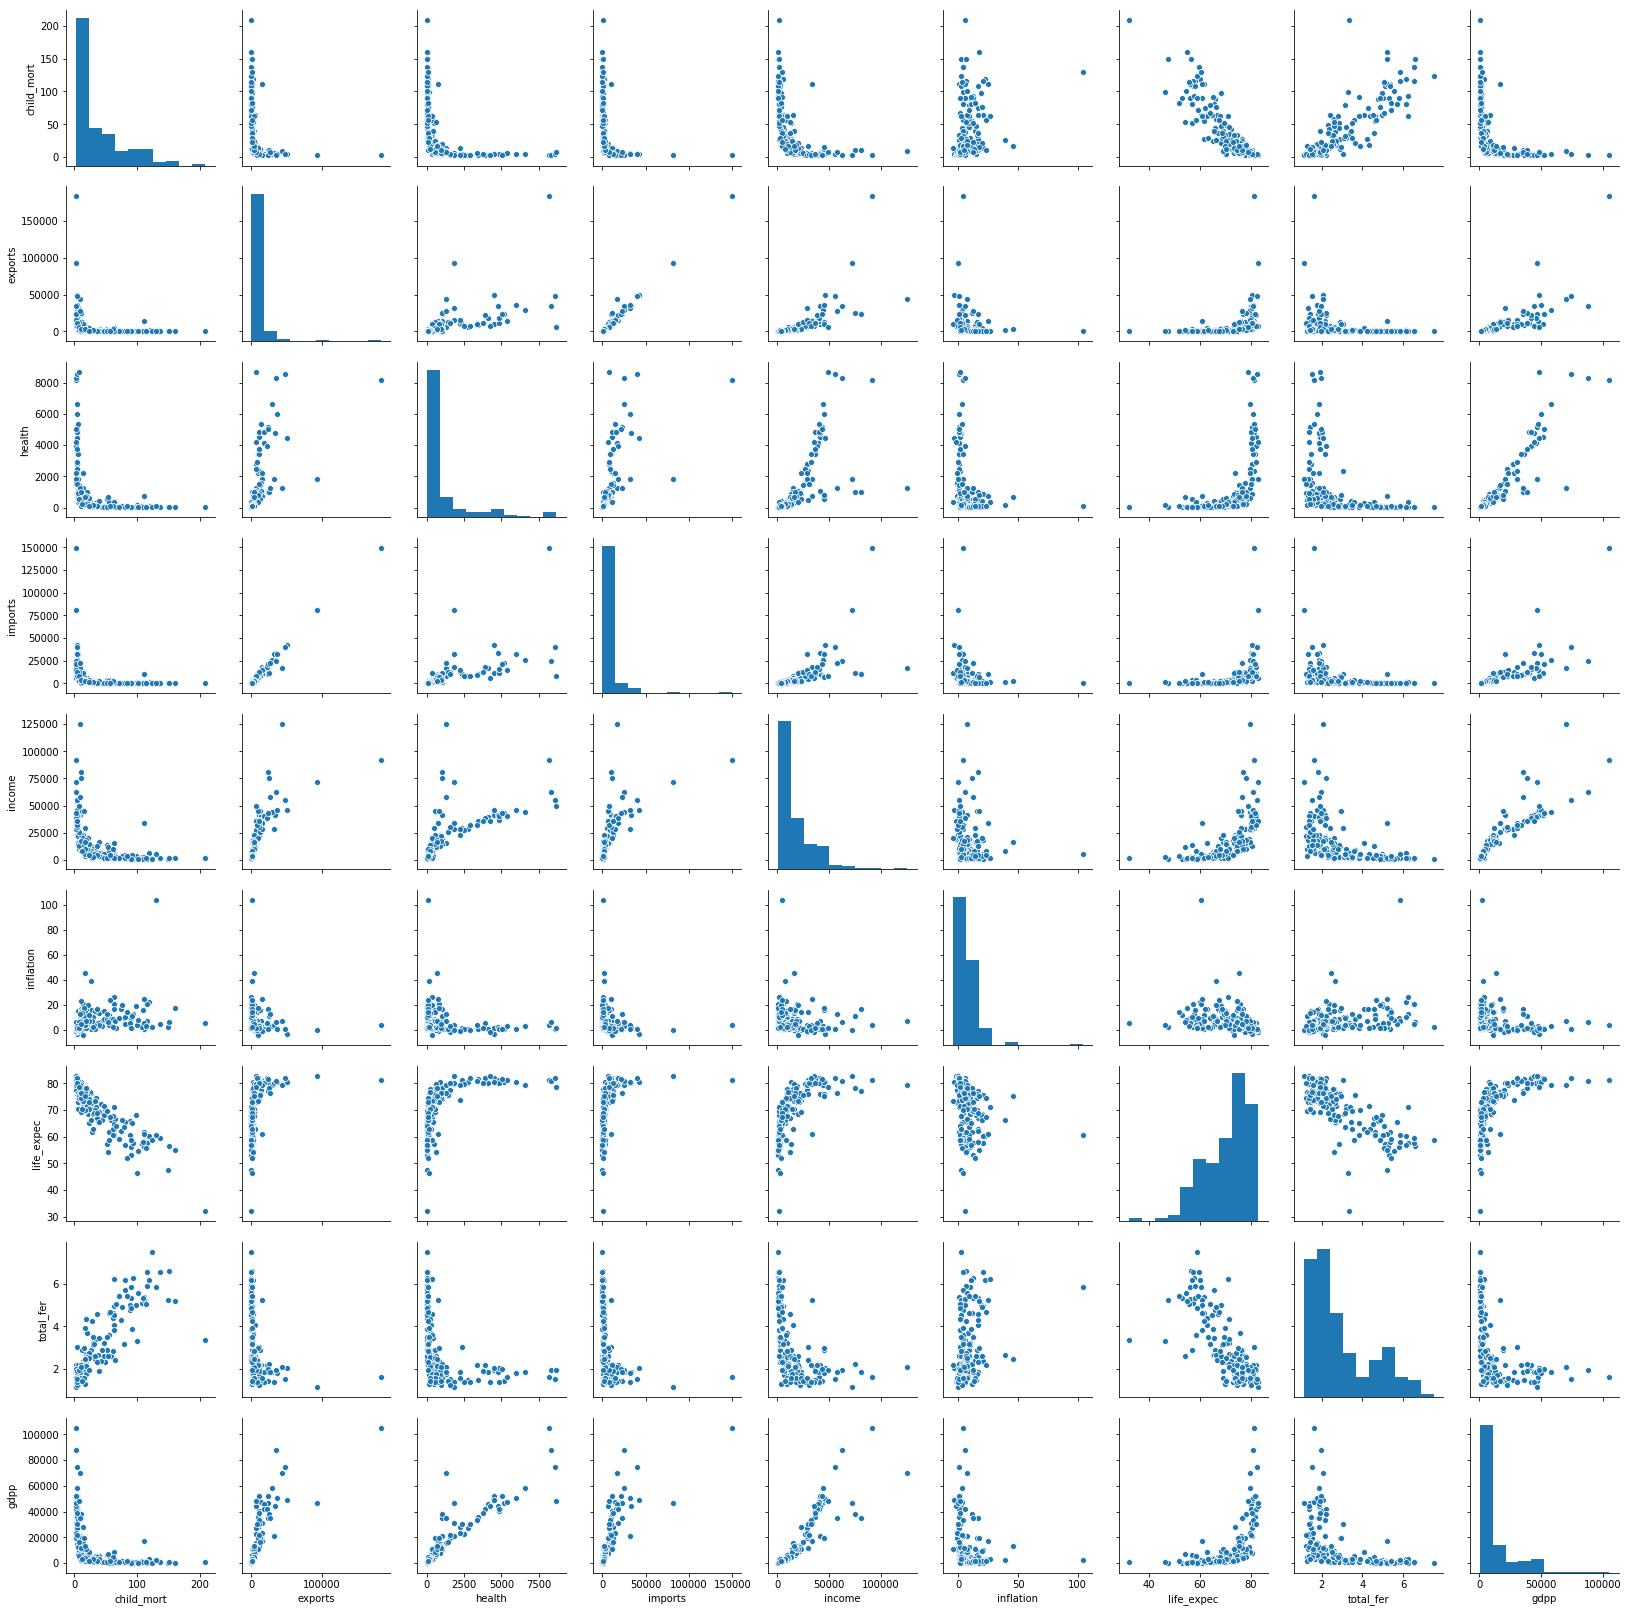

In [12]:
sns.pairplot(country)
plt.show()

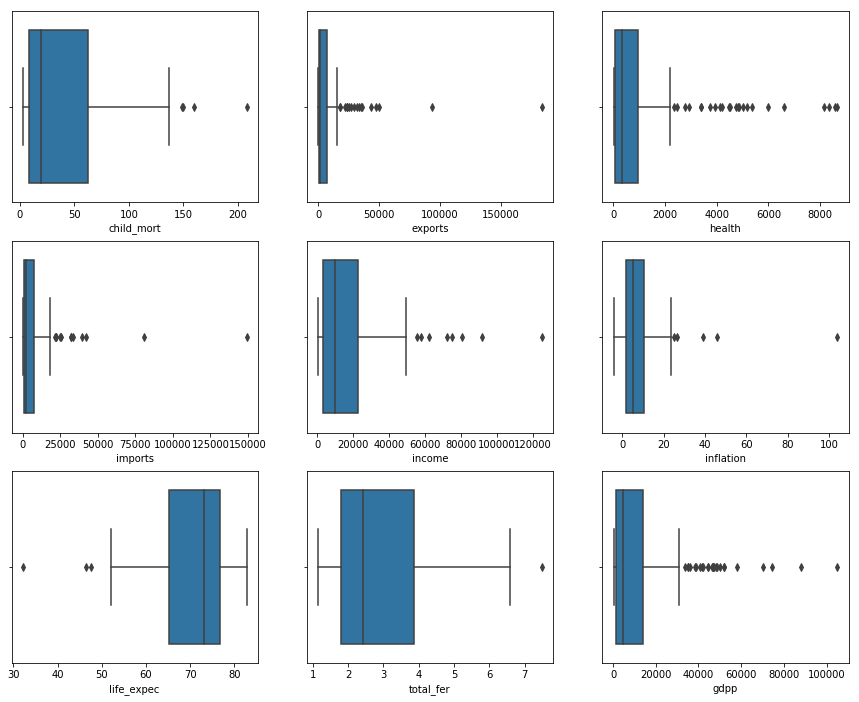

In [13]:
columns = country.columns.tolist()
columns.remove('country')
plt.figure(figsize=(15,12))
i=1
for column in columns:
    plt.subplot(3,3,i)
    sns.boxplot(x=column,data=country)
    i = i+1


In [14]:
data = country.copy()

data.shape

(167, 10)

In [15]:
data.loc[data.child_mort<country.child_mort.quantile(0.05),'child_mort'] = country.child_mort.quantile(0.05)
data.loc[data.child_mort>country.child_mort.quantile(0.95),'child_mort'] = country.child_mort.quantile(0.95)

data.loc[data.exports<country.exports.quantile(0.05),'exports'] = country.exports.quantile(0.05)
data.loc[data.exports>country.exports.quantile(0.95),'exports'] = country.exports.quantile(0.95)

data.loc[data.health<country.health.quantile(0.05),'health'] = country.health.quantile(0.05)
data.loc[data.health>country.health.quantile(0.95),'health'] = country.health.quantile(0.95)

data.loc[data.imports<country.imports.quantile(0.05),'imports'] = country.imports.quantile(0.05)
data.loc[data.imports>country.imports.quantile(0.95),'imports'] = country.imports.quantile(0.95)

data.loc[data.income<country.income.quantile(0.05),'income'] = country.income.quantile(0.05)
data.loc[data.income>country.income.quantile(0.95),'income'] = country.income.quantile(0.95)

data.loc[data.inflation<country.inflation.quantile(0.05),'inflation'] = country.inflation.quantile(0.05)
data.loc[data.inflation>country.inflation.quantile(0.95),'inflation'] = country.inflation.quantile(0.95)

data.loc[data.life_expec<country.life_expec.quantile(0.05),'life_expec'] = country.life_expec.quantile(0.05)
data.loc[data.life_expec>country.life_expec.quantile(0.95),'life_expec'] = country.life_expec.quantile(0.95)

data.loc[data.total_fer<country.total_fer.quantile(0.05),'total_fer'] = country.total_fer.quantile(0.05)
data.loc[data.total_fer>country.total_fer.quantile(0.95),'total_fer'] = country.total_fer.quantile(0.95)

data.loc[data.gdpp<country.gdpp.quantile(0.05),'gdpp'] = country.gdpp.quantile(0.05)
data.loc[data.gdpp>country.gdpp.quantile(0.95),'gdpp'] = country.gdpp.quantile(0.95)

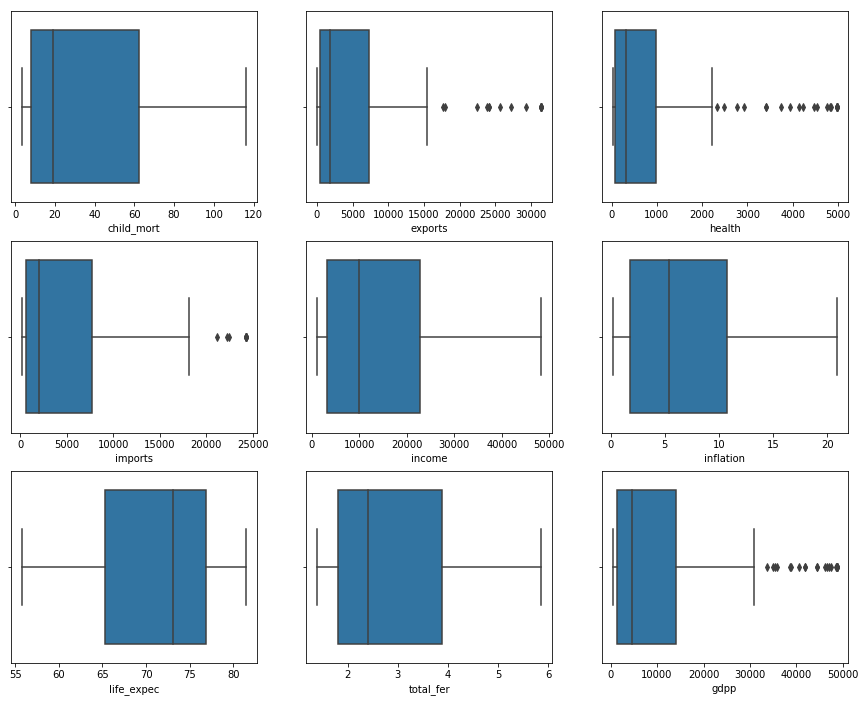

In [16]:
columns = country.columns.tolist()
columns.remove('country')
plt.figure(figsize=(15,12))
i=1
for column in columns:
    plt.subplot(3,3,i)
    sns.boxplot(x=column,data=data)
    i = i+1


We can see that there are some outliers present

Since our focus here is to identify the weak countries we can cap the max and min of the data columns to reduce the effect of such outliers. We will be using 0.05 and 0.95 percentiles as the cap values. Since it is only 1% of the rows and the number of rows is small, the effect of this imputation will not effect the clustering analysis negatively

we can see that most of the outliers are handled

### Correlation check

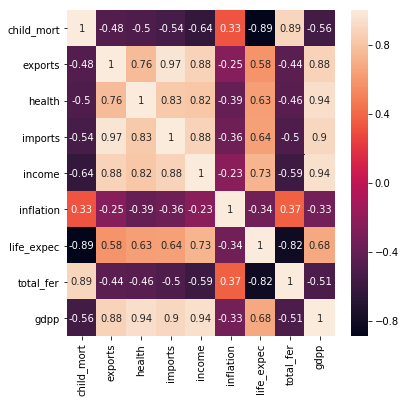

In [17]:
plt.figure(figsize = (6,6))
sns.heatmap(data.corr(),annot = True)
plt.show()

We can see that there are some highly correlated features

# Standardizing Values

In [18]:
data.drop('country',axis = 1,inplace = True)

In [19]:
#Standardizing the values for PCA
scaler = StandardScaler()
data_stan = scaler.fit_transform(data)

In [20]:
data_stan

array([[ 1.47958789, -0.6680385 , -0.62977664, ..., -1.82530988,
         2.02071786, -0.7578739 ],
       [-0.56002364, -0.54238923, -0.47380369, ...,  0.68245351,
        -0.88733091, -0.52377507],
       [-0.26350403, -0.47604845, -0.53034544, ...,  0.70740638,
        -0.02258739, -0.49928636],
       ...,
       [-0.37435248, -0.56600554, -0.59686758, ...,  0.2832076 ,
        -0.67811877, -0.70777132],
       [ 0.54014725, -0.63033074, -0.61187267, ..., -0.41547275,
         1.21873798, -0.70777132],
       [ 1.28283189, -0.61312124, -0.59935922, ..., -1.8777109 ,
         1.72782086, -0.69784347]])

In [21]:
data_stan.shape

(167, 9)

# PCA

In [22]:
pca = PCA(svd_solver='randomized',random_state = 42)
pca.fit(data_stan)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [23]:
print(pca.components_)
#the following the 9 pca components
print('*'*80)
print(len(pca.components_))

[[-0.31370269  0.3507987   0.35117814  0.36823124  0.3760003  -0.17399219
   0.34308686 -0.29811055  0.37600872]
 [ 0.48684115  0.33097567  0.24315701  0.26930019  0.16807184  0.20045717
  -0.34450383  0.518471    0.25664488]
 [-0.17763585  0.06865397 -0.13607875 -0.04200438  0.17010205  0.93794122
   0.15426052 -0.10473963 -0.00389904]
 [ 0.02276933 -0.53686271  0.64515566 -0.38273615  0.01264167  0.10608178
   0.18223758  0.1531131   0.28368977]
 [ 0.12839552 -0.08487898  0.20033773 -0.044213    0.07457927  0.0793257
  -0.67371545 -0.67970453  0.08046591]
 [ 0.10763991 -0.12068467 -0.42310587 -0.38460022  0.74879473 -0.17145686
  -0.0364004   0.06088446  0.22757426]
 [-0.77529381 -0.03982588  0.03717355  0.00485011  0.05733246 -0.0244068
  -0.50118521  0.37360531  0.03574583]
 [-0.05482802  0.44271465 -0.15457498 -0.4975912  -0.43826551 -0.00918345
  -0.01115888 -0.04842649  0.5786852 ]
 [ 0.01857455 -0.50508301 -0.37198959  0.49612416 -0.19915279  0.04676013
  -0.00854657 -0.0165131

In [24]:
print('expained variance ratio of pca components:')
print(pca.explained_variance_ratio_)

expained variance ratio of pca components:
[0.68508867 0.14727819 0.09507099 0.03147493 0.01636993 0.0119143
 0.00890517 0.00252245 0.00137538]


### Scree plot for deciding on number of components

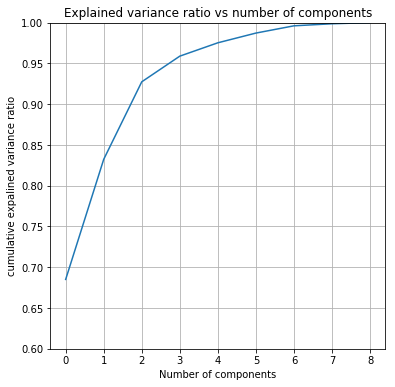

In [25]:
%matplotlib inline
plt.figure(figsize=(6,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('cumulative expalined variance ratio')
plt.yticks(np.arange(0,1.1,0.05))
plt.ylim(0.6,1)
plt.grid()
plt.title('Explained variance ratio vs number of components')
plt.show()

From the figure we can see that about 93% of the variance is expanined with 2 PCs. Hence we can go ahead with 2 PCs

In [26]:
inc_pca = IncrementalPCA(n_components = 2)
data_pc = inc_pca.fit_transform(data_stan)

In [27]:
inc_pca.components_

array([[-0.31406896,  0.35067239,  0.35143991,  0.3680073 ,  0.37629547,
        -0.17193835,  0.34333138, -0.29811088,  0.37622143],
       [ 0.4968474 ,  0.32503173,  0.25210179,  0.27089053,  0.15793747,
         0.1495399 , -0.35238477,  0.52240725,  0.25723386]])

In [28]:
pc_columns = []
for x in range(1,3):
    pc_columns.append('PC'+str(x))

In [29]:
pc_feature_df = pd.concat([pd.DataFrame(np.transpose(inc_pca.components_),columns = pc_columns),pd.DataFrame(data.columns.tolist(),columns = ['feature'])],axis = 1)

In [30]:
pc_feature_df

,PC1,PC2,feature
0,-0.314069,0.496847,child_mort
1,0.350672,0.325032,exports
2,0.351440,0.252102,health
3,0.368007,0.270891,imports
4,0.376295,0.157937,income
5,-0.171938,0.149540,inflation
6,0.343331,-0.352385,life_expec
7,-0.298111,0.522407,total_fer
8,0.376221,0.257234,gdpp


Since PC1 explains majority of the variance and `gdpp,income,life_expec,child_mort` are the factors that influence the most. exports,imports and health are ingnored because they are percentage values of gdp and hence their consideration is already present in the gdp

### Plotting features using PC1 and PC2

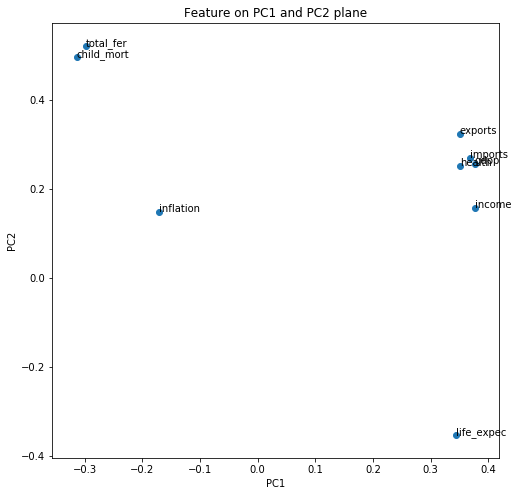

In [31]:
%matplotlib inline
plt.figure(figsize=(8,8))
plt.scatter(pc_feature_df.PC1,pc_feature_df.PC2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Feature on PC1 and PC2 plane')
for i,text in enumerate(pc_feature_df.feature):
    plt.annotate(text,(pc_feature_df.PC1[i],pc_feature_df.PC2[i]))
plt.show()

In [32]:
data_pc_df = pd.DataFrame((data_pc),columns = pc_columns)

In [33]:
data_pc_df.head()

,PC1,PC2
0,-3.132468,1.570745
1,-0.132395,-1.663690
2,-0.737890,-0.774115
3,-3.157727,2.281999
4,0.944902,-0.974280


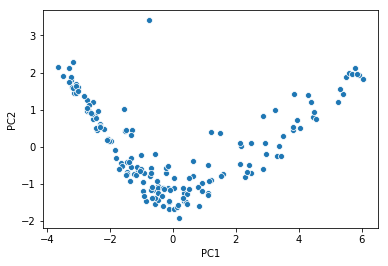

In [34]:
sns.scatterplot(x='PC1',y='PC2',data=data_pc_df)

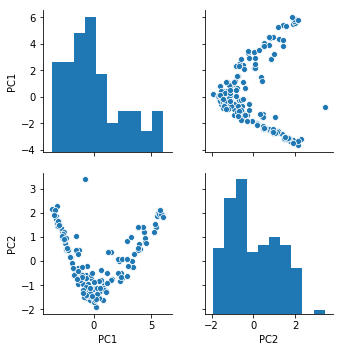

In [35]:
sns.pairplot(data_pc_df)
plt.show()

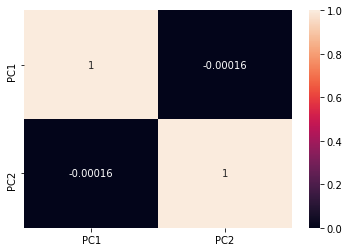

In [36]:
sns.heatmap(data_pc_df.corr(),annot= True)
plt.show()
# almost 0 correlation

# Clustering

In [37]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [38]:
hopkins(data_pc_df)

0.8433823419048897

hopkins coefficient is more than 0.7 hence the data can be clusted

## KMeans clustering

We will plot silhouette and elbow curves and decide on the ideal number of cluster suited for this problem

### Silhoute score

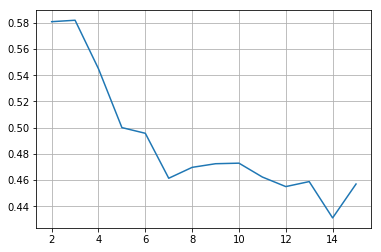

In [39]:
plt.figure(figsize=(6,6))
%matplotlib inline
sse = []
for num_clusters in range(2,16):
    kmeans = KMeans(n_clusters = num_clusters,random_state = 42).fit(data_pc_df)
    sse.append([num_clusters,silhouette_score(data_pc_df,kmeans.labels_)])
plt.plot(pd.DataFrame(sse)[0],pd.DataFrame(sse)[1])
plt.grid()
plt.show()

### Elbow curve

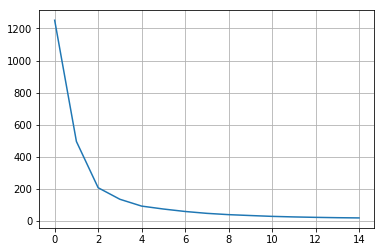

In [40]:
ssd = []
for num_clusters in list(range(1,16)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(data_pc_df)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)
plt.grid()
plt.show()

### 2 clusters vs 3 clusters

In [41]:
kmeans2 = KMeans(n_clusters = 2,random_state = 42)
kmeans2.fit(data_pc_df)
km_clus2=data_pc_df
km_clus2.index = pd.RangeIndex(len(km_clus2.index))
km_clus2 = pd.concat([km_clus2, pd.Series(kmeans2.labels_)], axis=1)
km_clus2.columns = ['PC1', 'PC2','ClusterID']

km_clus2['ClusterID'].value_counts()


0    127
1     40
Name: ClusterID, dtype: int64

In [42]:
combined_km2 = pd.merge(country,km_clus2, left_index=True,right_index=True)
combined_km2.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,ClusterID
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,-3.132468,1.570745,0
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090,-0.132395,-1.663690,0
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,-0.737890,-0.774115,0
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,-3.157727,2.281999,0
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,0.944902,-0.974280,0


In [43]:
childmor_km2 = combined_km2.groupby('ClusterID').child_mort.mean().reset_index()
exports_km2 = combined_km2.groupby('ClusterID').exports.mean()
health_km2 = combined_km2.groupby('ClusterID').health.mean()
imports_km2 = combined_km2.groupby('ClusterID').imports.mean()
income_km2 = combined_km2.groupby('ClusterID').income.mean()
inflation_km2 = combined_km2.groupby('ClusterID').inflation.mean()
life_expec_km2 = combined_km2.groupby('ClusterID').life_expec.mean()
total_fer_km2 = combined_km2.groupby('ClusterID').total_fer.mean()
gdpp_km2 = combined_km2.groupby('ClusterID').gdpp.mean()

km_anal2 = pd.concat([childmor_km2,exports_km2,health_km2,imports_km2,income_km2,inflation_km2,life_expec_km2,total_fer_km2,gdpp_km2],axis = 1)

In [44]:
km_anal2

,ClusterID,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,48.622835,1862.565748,278.482913,1964.833858,8706.795276,9.323811,67.699213,3.31874,4411.133858
1,1,5.400000,25067.437500,3527.677750,21268.022500,43935.000000,2.886050,79.625000,1.77075,40120.000000


In [45]:
kmeans3 = KMeans(n_clusters = 3,random_state = 42)
kmeans3.fit(data_pc_df)
km_clus3=data_pc_df
km_clus3.index = pd.RangeIndex(len(km_clus3.index))
km_clus3 = pd.concat([km_clus3, pd.Series(kmeans3.labels_)], axis=1)
km_clus3.columns = ['PC1', 'PC2','ClusterID']

km_clus3['ClusterID'].value_counts()


0    81
2    49
1    37
Name: ClusterID, dtype: int64

In [46]:
combined_km3 = pd.merge(country,km_clus3, left_index=True,right_index=True)
combined_km3.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,ClusterID
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,-3.132468,1.570745,2
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090,-0.132395,-1.663690,0
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,-0.737890,-0.774115,0
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,-3.157727,2.281999,2
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,0.944902,-0.974280,0


In [47]:
childmor_km3 = combined_km3.groupby('ClusterID').child_mort.mean().reset_index()
exports_km3 = combined_km3.groupby('ClusterID').exports.mean()
health_km3 = combined_km3.groupby('ClusterID').health.mean()
imports_km3 = combined_km3.groupby('ClusterID').imports.mean()
income_km3 = combined_km3.groupby('ClusterID').income.mean()
inflation_km3 = combined_km3.groupby('ClusterID').inflation.mean()
life_expec_km3 = combined_km3.groupby('ClusterID').life_expec.mean()
total_fer_km3 = combined_km3.groupby('ClusterID').total_fer.mean()
gdpp_km3 = combined_km3.groupby('ClusterID').gdpp.mean()

km_anal3 = pd.concat([childmor_km3,exports_km3,health_km3,imports_km3,income_km3,inflation_km3,life_expec_km3,total_fer_km3,gdpp_km3],axis = 1)
km_anal3

,ClusterID,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,21.575309,2822.238765,397.369877,2930.954938,12430.617284,7.648877,72.979012,2.274321,6355.975309
1,1,5.237838,26171.270270,3749.510541,22235.610811,45056.756757,2.588432,79.956757,1.755676,42102.702703
2,2,90.810204,863.367551,113.379388,818.976531,3860.877551,11.923163,59.451020,4.961837,1885.306122


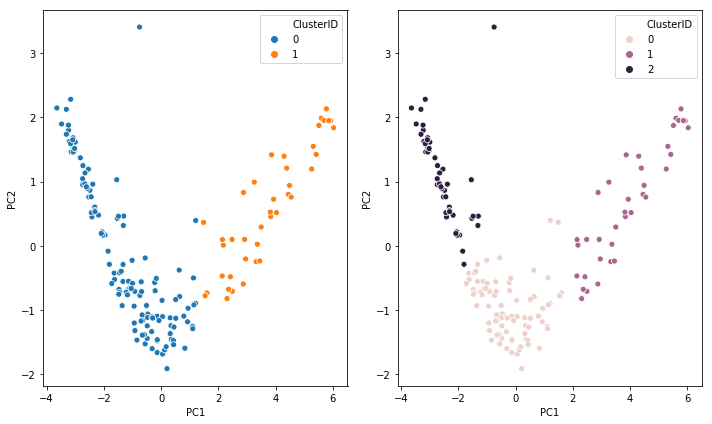

In [48]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.scatterplot(x='PC1',y='PC2',data = combined_km2,hue='ClusterID',legend = 'full')
plt.subplot(1,2,2)
sns.scatterplot(x='PC1',y='PC2',data = combined_km3,hue='ClusterID',legend = 'full')
plt.tight_layout()
plt.show()

From the above graphs and analysis we can decide on 3 clusters which maximizes the silhoutte score and also the clusters formed made more sense with 3 clusters

### Final Kmeans cluster

In [49]:
kmeans_final = KMeans(n_clusters = 3,random_state = 42)

In [50]:
kmeans_final.fit(data_pc_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [51]:
km_clus=data_pc_df
km_clus.index = pd.RangeIndex(len(km_clus.index))
km_clus = pd.concat([km_clus, pd.Series(kmeans_final.labels_)], axis=1)
km_clus.columns = ['PC1', 'PC2','ClusterID']
km_clus.head()

,PC1,PC2,ClusterID
0,-3.132468,1.570745,2
1,-0.132395,-1.663690,0
2,-0.737890,-0.774115,0
3,-3.157727,2.281999,2
4,0.944902,-0.974280,0


In [52]:
km_clus['ClusterID'].value_counts()

0    81
2    49
1    37
Name: ClusterID, dtype: int64

### Clusters with Axis as Principal components

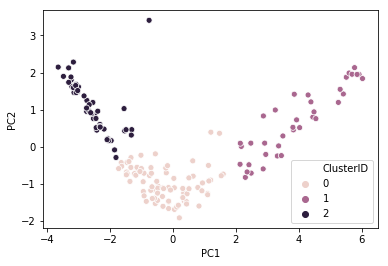

In [53]:
sns.scatterplot(x='PC1',y='PC2',data = km_clus,hue='ClusterID',legend = 'full')
plt.show()

In [54]:
combined_km = pd.merge(country,km_clus, left_index=True,right_index=True)
combined_km.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,ClusterID
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,-3.132468,1.570745,2
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090,-0.132395,-1.663690,0
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,-0.737890,-0.774115,0
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,-3.157727,2.281999,2
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,0.944902,-0.974280,0


### Clusters with features

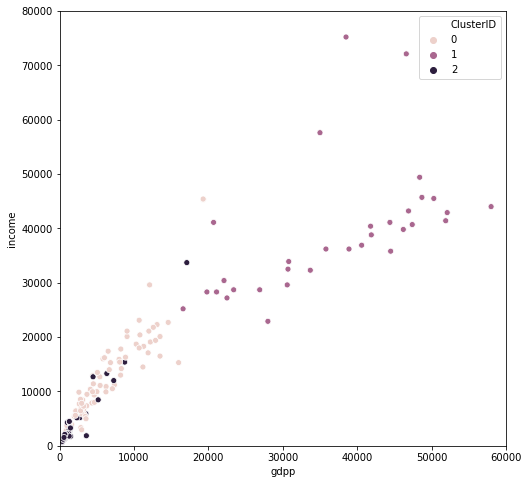

In [55]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='gdpp',y='income',data = combined_km,hue='ClusterID',legend = 'full')
plt.ylim(0,80000)
plt.xlim(0,60000)
plt.show()

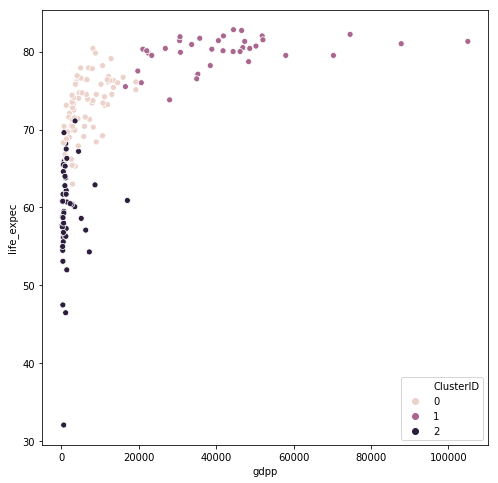

In [56]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='gdpp',y='life_expec',data = combined_km,hue='ClusterID',legend = 'full')
plt.show()

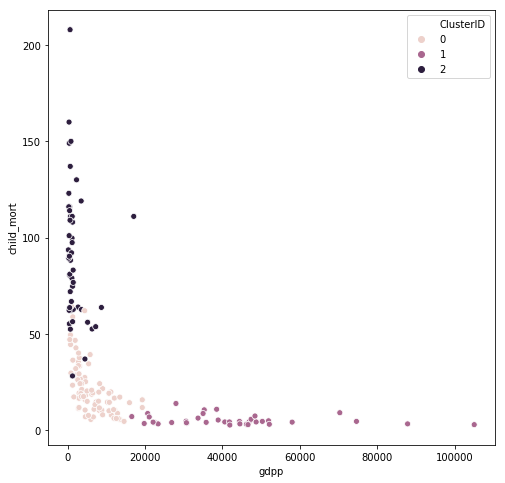

In [57]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='gdpp',y='child_mort',data = combined_km,hue='ClusterID',legend = 'full')
plt.show()

In [58]:
childmor_km = combined_km.groupby('ClusterID').child_mort.mean().reset_index()
exports_km = combined_km.groupby('ClusterID').exports.mean()
health_km = combined_km.groupby('ClusterID').health.mean()
imports_km = combined_km.groupby('ClusterID').imports.mean()
income_km = combined_km.groupby('ClusterID').income.mean()
inflation_km = combined_km.groupby('ClusterID').inflation.mean()
life_expec_km = combined_km.groupby('ClusterID').life_expec.mean()
total_fer_km = combined_km.groupby('ClusterID').total_fer.mean()
gdpp_km = combined_km.groupby('ClusterID').gdpp.mean()

In [59]:
km_anal = pd.concat([childmor_km,exports_km,health_km,imports_km,income_km,inflation_km,life_expec_km,total_fer_km,gdpp_km],axis = 1)

In [60]:
km_anal

,ClusterID,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,21.575309,2822.238765,397.369877,2930.954938,12430.617284,7.648877,72.979012,2.274321,6355.975309
1,1,5.237838,26171.270270,3749.510541,22235.610811,45056.756757,2.588432,79.956757,1.755676,42102.702703
2,2,90.810204,863.367551,113.379388,818.976531,3860.877551,11.923163,59.451020,4.961837,1885.306122


# Analysis of features based on the clusters

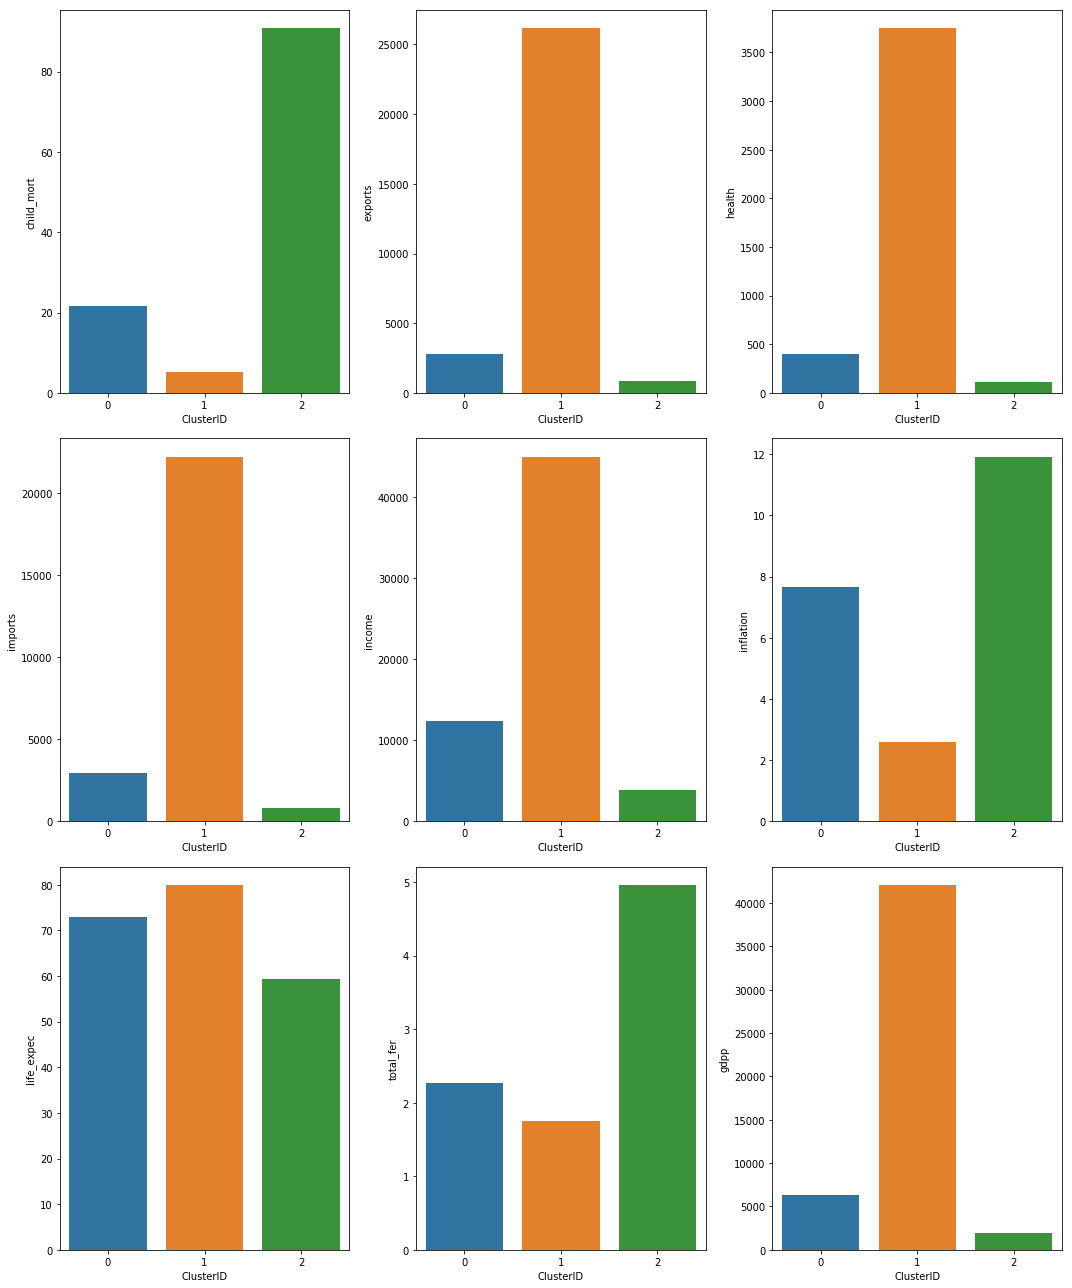

In [61]:
plt.figure(figsize = (15,18))
plot_columns = km_anal.columns.tolist()
plot_columns.remove('ClusterID')
i=1
for x in plot_columns:
    plt.subplot(3,3,i)
    sns.barplot(x='ClusterID',y=x,data=km_anal)
    i=i+1
plt.tight_layout()
plt.show()

### K-Means Analysis:

    - we can see that 3 clusters are formed
    - cluster1 is the one with richer countries, which can be seen from lower child mortality rate, higher gdp and higher life expectency
    - Cluster2 consists of poor countries which require assistance, this can seen from the above plots which show   higher child mortality, lower life expectency,lower gdp and higher fertility rate

# Hierarchial Clustering

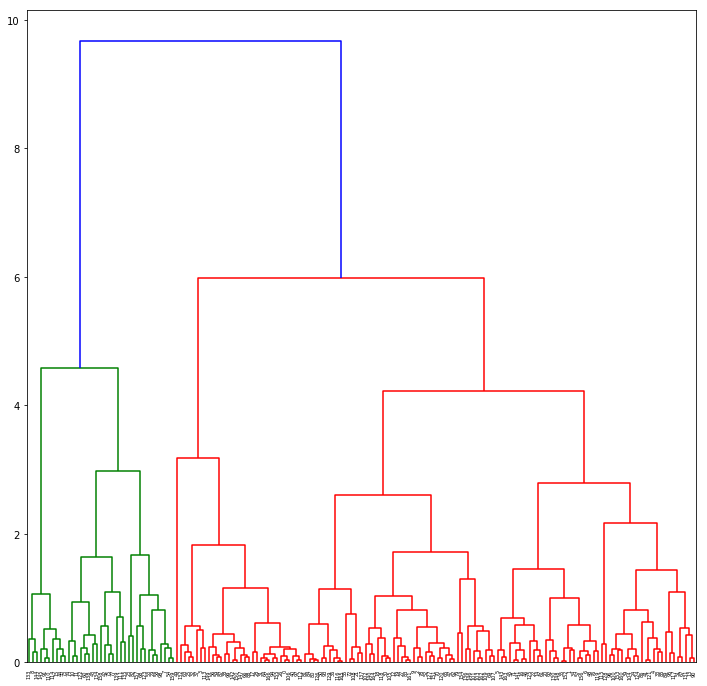

In [62]:
# heirarchical clustering
fig = plt.figure(figsize = (12,12))
mergings = linkage(data_pc_df, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

### 5 clusters

In [63]:
clustercut5 = pd.Series(cut_tree(mergings, n_clusters = 5).reshape(-1,))
cluster_hc5 = pd.concat([country, clustercut5,data_pc_df], axis=1)
cluster_hc5.columns = [ 'country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp',
                  'ClusterID','PC1','PC2']
cluster_hc5.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID,PC1,PC2
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,0,-3.132468,1.570745
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090,1,-0.132395,-1.663690
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,2,-0.737890,-0.774115
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,0,-3.157727,2.281999
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,1,0.944902,-0.974280


In [64]:
cluster_hc5.ClusterID.value_counts()

1    50
2    48
0    32
3    27
4    10
Name: ClusterID, dtype: int64

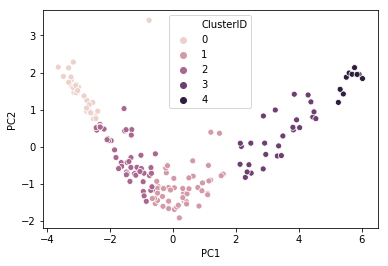

In [65]:
sns.scatterplot(x='PC1',y='PC2',data = cluster_hc5,hue='ClusterID',legend = 'full')
plt.show()

In [66]:
childmor_hc5 = cluster_hc5.groupby('ClusterID').child_mort.mean().reset_index()
exports_hc5 = cluster_hc5.groupby('ClusterID').exports.mean()
health_hc5 = cluster_hc5.groupby('ClusterID').health.mean()
imports_hc5 = cluster_hc5.groupby('ClusterID').imports.mean()
income_hc5 = cluster_hc5.groupby('ClusterID').income.mean()
inflation_hc5 = cluster_hc5.groupby('ClusterID').inflation.mean()
life_expec_hc5 = cluster_hc5.groupby('ClusterID').life_expec.mean()
total_fer_hc5 = cluster_hc5.groupby('ClusterID').total_fer.mean()
gdpp_hc5 = cluster_hc5.groupby('ClusterID').gdpp.mean()

hc_cluster_anal5 = pd.concat([childmor_hc5,exports_hc5,health_hc5,imports_hc5,income_hc5,inflation_hc5,life_expec_hc5,total_fer_hc5,gdpp_hc5],axis = 1)

hc_cluster_anal5

,ClusterID,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,106.818750,796.898438,82.872187,720.932500,3085.406250,13.652031,57.643750,5.445625,1534.625000
1,1,13.970000,3877.991200,551.656800,3954.506400,15996.800000,6.548960,75.000000,1.953800,8569.800000
2,2,43.345833,1073.042500,156.412500,1182.125833,6197.708333,9.155854,67.287500,3.237500,2700.333333
3,3,5.774074,15224.737037,2956.493704,13020.548148,41596.296296,3.012556,79.577778,1.767407,34940.740741
4,4,3.790000,55726.910000,5890.656000,47116.280000,54400.000000,1.443300,80.980000,1.724000,61440.000000


### 3 clusters

In [67]:
clustercut = pd.Series(cut_tree(mergings, n_clusters = 3).reshape(-1,))
cluster_hc = pd.concat([country, clustercut,data_pc_df], axis=1)
cluster_hc.columns = [ 'country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp',
                  'ClusterID','PC1','PC2']
cluster_hc.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,ClusterID,PC1,PC2
0,Afghanistan,90.2,55.30,41.92,248.30,1610,9.44,56.2,5.82,553,0,-3.132468,1.570745
1,Albania,16.6,1145.20,267.90,1987.74,9930,4.49,76.3,1.65,4090,1,-0.132395,-1.663690
2,Algeria,27.3,1712.64,185.98,1400.44,12900,16.10,76.5,2.89,4460,1,-0.737890,-0.774115
3,Angola,119.0,2199.19,100.60,1514.37,5900,22.40,60.1,6.16,3530,0,-3.157727,2.281999
4,Antigua and Barbuda,10.3,5551.00,735.66,7185.80,19100,1.44,76.8,2.13,12200,1,0.944902,-0.974280


In [68]:
cluster_hc.ClusterID.value_counts()

1    98
2    37
0    32
Name: ClusterID, dtype: int64

### Clusters with Axis as Principal components

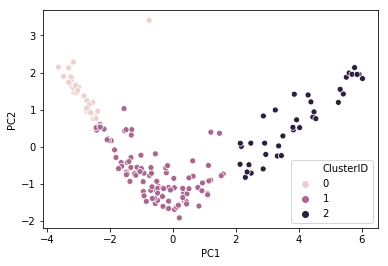

In [69]:
sns.scatterplot(x='PC1',y='PC2',data = cluster_hc,hue='ClusterID',legend = 'full')
plt.show()

In [70]:
childmor_hc = cluster_hc.groupby('ClusterID').child_mort.mean().reset_index()
exports_hc = cluster_hc.groupby('ClusterID').exports.mean()
health_hc = cluster_hc.groupby('ClusterID').health.mean()
imports_hc = cluster_hc.groupby('ClusterID').imports.mean()
income_hc = cluster_hc.groupby('ClusterID').income.mean()
inflation_hc = cluster_hc.groupby('ClusterID').inflation.mean()
life_expec_hc = cluster_hc.groupby('ClusterID').life_expec.mean()
total_fer_hc = cluster_hc.groupby('ClusterID').total_fer.mean()
gdpp_hc = cluster_hc.groupby('ClusterID').gdpp.mean()

hc_cluster_anal = pd.concat([childmor_hc,exports_hc,health_hc,imports_hc,income_hc,inflation_hc,life_expec_hc,total_fer_hc,gdpp_hc],axis = 1)

hc_cluster_anal

,ClusterID,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,106.818750,796.898438,82.872187,720.932500,3085.406250,13.652031,57.643750,5.445625,1534.625000
1,1,28.358163,2504.138776,358.067755,2596.605714,11197.244898,7.825806,71.222449,2.582551,5694.959184
2,2,5.237838,26171.270270,3749.510541,22235.610811,45056.756757,2.588432,79.956757,1.755676,42102.702703


### 3 clusters vs 5 clusters

In [71]:
print('with 3 clusters:')
print(cluster_hc.ClusterID.value_counts())

print('\nwith 5 clusters:')
print(cluster_hc5.ClusterID.value_counts())


with 3 clusters:
1    98
2    37
0    32
Name: ClusterID, dtype: int64

with 5 clusters:
1    50
2    48
0    32
3    27
4    10
Name: ClusterID, dtype: int64


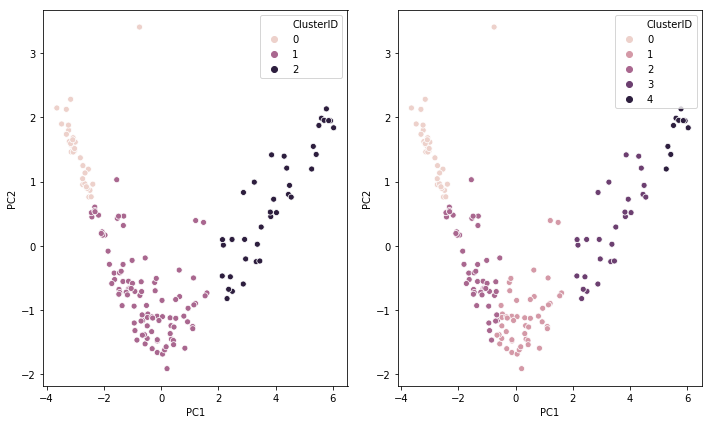

In [72]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.scatterplot(x='PC1',y='PC2',data = cluster_hc,hue='ClusterID',legend = 'full')
plt.subplot(1,2,2)
sns.scatterplot(x='PC1',y='PC2',data = cluster_hc5,hue='ClusterID',legend = 'full')
plt.tight_layout()
plt.show()

In [73]:
set(cluster_hc[cluster_hc.ClusterID == 0].country)-set(cluster_hc[cluster_hc5.ClusterID == 0].country)

set()

In [74]:
hc_cluster_anal

,ClusterID,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,106.818750,796.898438,82.872187,720.932500,3085.406250,13.652031,57.643750,5.445625,1534.625000
1,1,28.358163,2504.138776,358.067755,2596.605714,11197.244898,7.825806,71.222449,2.582551,5694.959184
2,2,5.237838,26171.270270,3749.510541,22235.610811,45056.756757,2.588432,79.956757,1.755676,42102.702703


In [75]:
hc_cluster_anal5

,ClusterID,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0,106.818750,796.898438,82.872187,720.932500,3085.406250,13.652031,57.643750,5.445625,1534.625000
1,1,13.970000,3877.991200,551.656800,3954.506400,15996.800000,6.548960,75.000000,1.953800,8569.800000
2,2,43.345833,1073.042500,156.412500,1182.125833,6197.708333,9.155854,67.287500,3.237500,2700.333333
3,3,5.774074,15224.737037,2956.493704,13020.548148,41596.296296,3.012556,79.577778,1.767407,34940.740741
4,4,3.790000,55726.910000,5890.656000,47116.280000,54400.000000,1.443300,80.980000,1.724000,61440.000000


__Since identification of poor countries is the focus of this analysis, cluster0 is same for both 3 and 5 cluster analysis. hence we are considering 3 cluster, since there is no change in the cluster of poor countries__

### Cluster with original features

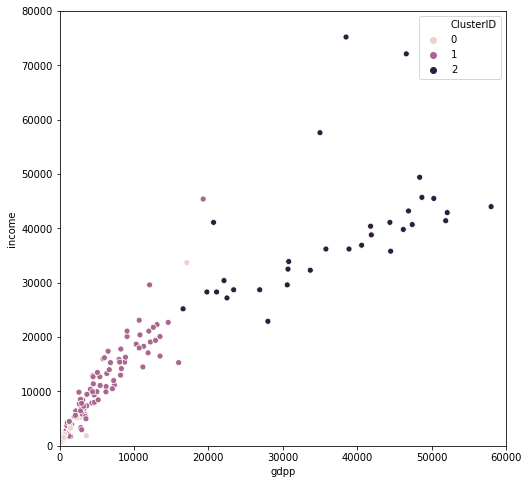

In [76]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='gdpp',y='income',data = cluster_hc,hue='ClusterID',legend = 'full')
plt.ylim(0,80000)
plt.xlim(0,60000)
plt.show()

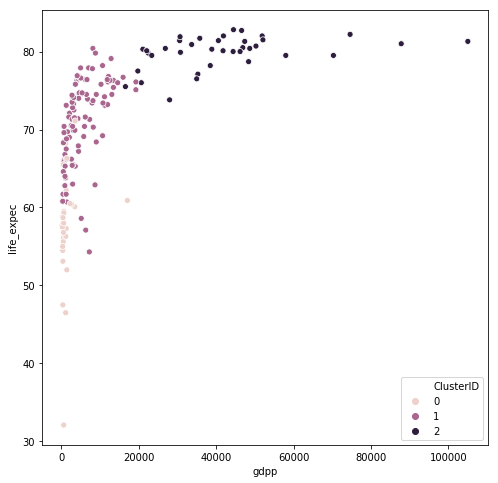

In [77]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='gdpp',y='life_expec',data = cluster_hc,hue='ClusterID',legend = 'full')
plt.show()

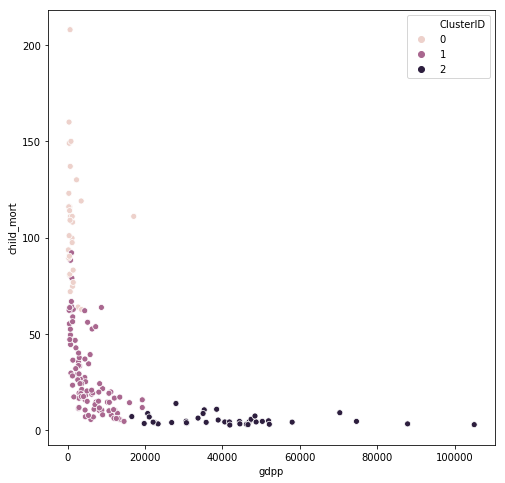

In [78]:
plt.figure(figsize=(8,8))
sns.scatterplot(x='gdpp',y='child_mort',data = cluster_hc,hue='ClusterID',legend = 'full')
plt.show()

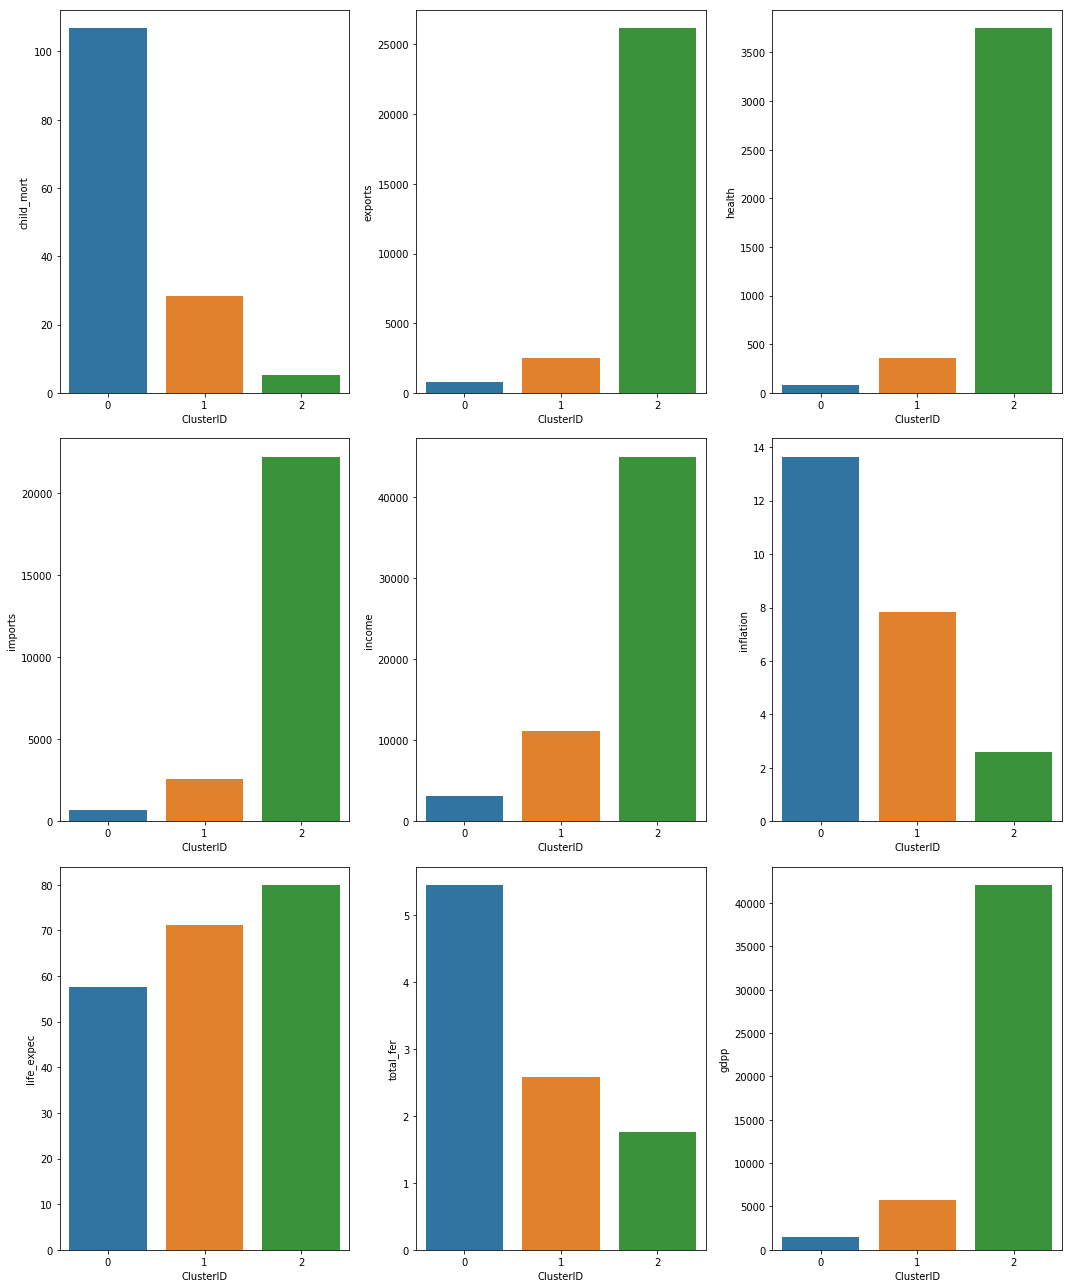

In [79]:
plt.figure(figsize = (15,18))
plot_columns = hc_cluster_anal.columns.tolist()
plot_columns.remove('ClusterID')
i=1
for x in plot_columns:
    plt.subplot(3,3,i)
    sns.barplot(x='ClusterID',y=x,data=hc_cluster_anal)
    i=i+1
plt.tight_layout()
plt.show()

### Hierarchial clustering Analysis:

    - we can see that 3 clusters are formed
    - cluster2 is the one with richer countries, which can be seen from lower child mortality rate, higher gdp and higher life expectency
    - Cluster0 consists of poor countries which require assistance, this can seen from the above plots which show   higher child mortality, lower life expectency,lower gdp and higher fertility rate

# Final list of countries

### list of countries from KMeans:

In [80]:
combined_km[combined_km.ClusterID ==2].country.tolist()

['Afghanistan',
 'Angola',
 'Benin',
 'Botswana',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Comoros',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Equatorial Guinea',
 'Eritrea',
 'Gabon',
 'Gambia',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'Iraq',
 'Kenya',
 'Kiribati',
 'Lao',
 'Lesotho',
 'Liberia',
 'Madagascar',
 'Malawi',
 'Mali',
 'Mauritania',
 'Mozambique',
 'Namibia',
 'Niger',
 'Nigeria',
 'Pakistan',
 'Rwanda',
 'Senegal',
 'Sierra Leone',
 'Solomon Islands',
 'South Africa',
 'Sudan',
 'Tajikistan',
 'Tanzania',
 'Timor-Leste',
 'Togo',
 'Uganda',
 'Yemen',
 'Zambia']

In [81]:
print(len(combined_km[combined_km.ClusterID ==2].country.tolist()))

49


### list of Hierarchial clustering:

In [82]:
cluster_hc[cluster_hc.ClusterID ==0].country.tolist()

['Afghanistan',
 'Angola',
 'Benin',
 'Burkina Faso',
 'Burundi',
 'Cameroon',
 'Central African Republic',
 'Chad',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 "Cote d'Ivoire",
 'Equatorial Guinea',
 'Gambia',
 'Ghana',
 'Guinea',
 'Guinea-Bissau',
 'Haiti',
 'Lesotho',
 'Liberia',
 'Malawi',
 'Mali',
 'Mauritania',
 'Mozambique',
 'Niger',
 'Nigeria',
 'Sierra Leone',
 'Sudan',
 'Tanzania',
 'Timor-Leste',
 'Togo',
 'Uganda',
 'Zambia']

In [83]:
print(len(cluster_hc[cluster_hc.ClusterID ==0].country.tolist()))

32


In [84]:
print('list of countries present in Kmeans and not present hierarchial clustering:\n')
print(set(combined_km[combined_km.ClusterID ==2].country.tolist())-set(cluster_hc[cluster_hc.ClusterID ==0].country.tolist()))

list of countries present in Kmeans and not present hierarchial clustering:

{'Kenya', 'Rwanda', 'Gabon', 'Yemen', 'Botswana', 'Eritrea', 'Senegal', 'Pakistan', 'Iraq', 'Comoros', 'Namibia', 'Madagascar', 'Tajikistan', 'Kiribati', 'Lao', 'Solomon Islands', 'South Africa'}


In [85]:
print('list of countries present in hierarchial clustering and not present in Kmeans :\n')
print(set(cluster_hc[cluster_hc.ClusterID ==0].country.tolist())-set(combined_km[combined_km.ClusterID ==2].country.tolist()))

list of countries present in hierarchial clustering and not present in Kmeans :

set()


We can see that all the countries from hierarchial clustering are present in Kmeans clustering. Therefore these 32 countries can be considered as the countries which require help. 

In [86]:
cluster_hc[cluster_hc.ClusterID ==0].sort_values(['life_expec'],ascending = True).head(10).country.tolist()

['Haiti',
 'Lesotho',
 'Central African Republic',
 'Zambia',
 'Malawi',
 'Mozambique',
 'Sierra Leone',
 'Guinea-Bissau',
 'Afghanistan',
 "Cote d'Ivoire"]

## List of countries

In [87]:
print(cluster_hc[cluster_hc.ClusterID ==0].country.tolist())

['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Lesotho', 'Liberia', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Niger', 'Nigeria', 'Sierra Leone', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Zambia']


The below are the 10 countries that i think require immediate help based on life expectency of the country. The lower life expentncy means that either the countries are subjected to regulat natural calamities or affected by the war.Either way they require immediate help

In [88]:
cluster_hc[cluster_hc.ClusterID ==0].sort_values(['life_expec'],ascending = True).head(10).country.tolist()

['Haiti',
 'Lesotho',
 'Central African Republic',
 'Zambia',
 'Malawi',
 'Mozambique',
 'Sierra Leone',
 'Guinea-Bissau',
 'Afghanistan',
 "Cote d'Ivoire"]

# Results:

### Results of PCA :

- 93% of variance is explained by 2 PCs, hence two PCs were considered

In [89]:
print(pc_feature_df)

        PC1       PC2     feature
0 -0.314069  0.496847  child_mort
1  0.350672  0.325032     exports
2  0.351440  0.252102      health
3  0.368007  0.270891     imports
4  0.376295  0.157937      income
5 -0.171938  0.149540   inflation
6  0.343331 -0.352385  life_expec
7 -0.298111  0.522407   total_fer
8  0.376221  0.257234        gdpp


- Since PC1 explains majority of the variance and `gdpp,income,life_expec,child_mort` are the factors that influence the most. exports,imports and health are ingnored because they are percentage values of gdp and hence their consideration is already present in the gdp

## Results of Clustering:

- 3 clusters were formed both through Kmeans clustering
- There are 49 countries that fall under a cluster which reuqires help
- 3 and 5 clusters are compared in hierarchial clustering and since the cluster of interest is same in both the scenarios, 3 clusters has been chosen
- The cluster that required socio economic assitance had 32 countries which are all present in the KMeans as well

#### plots

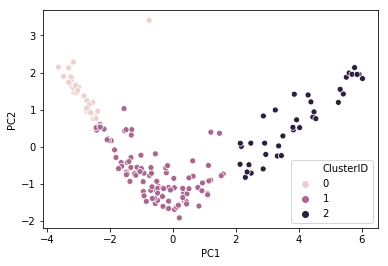

In [90]:
sns.scatterplot(x='PC1',y='PC2',data = cluster_hc,hue='ClusterID',legend = 'full')
plt.show()

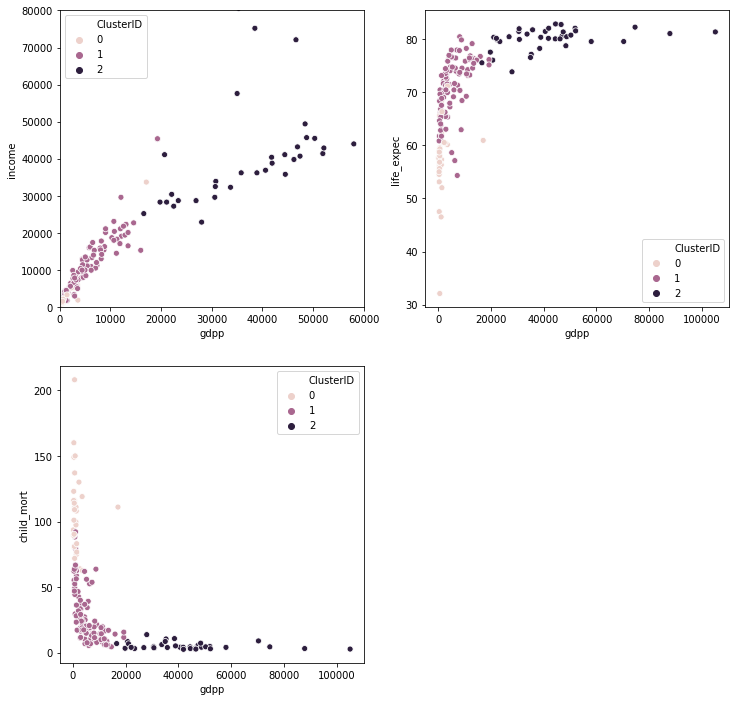

In [91]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.scatterplot(x='gdpp',y='income',data = cluster_hc,hue='ClusterID',legend = 'full')
plt.ylim(0,80000)
plt.xlim(0,60000)

plt.subplot(2,2,2)
sns.scatterplot(x='gdpp',y='life_expec',data = cluster_hc,hue='ClusterID',legend = 'full')

plt.subplot(2,2,3)
sns.scatterplot(x='gdpp',y='child_mort',data = cluster_hc,hue='ClusterID',legend = 'full')
plt.show()

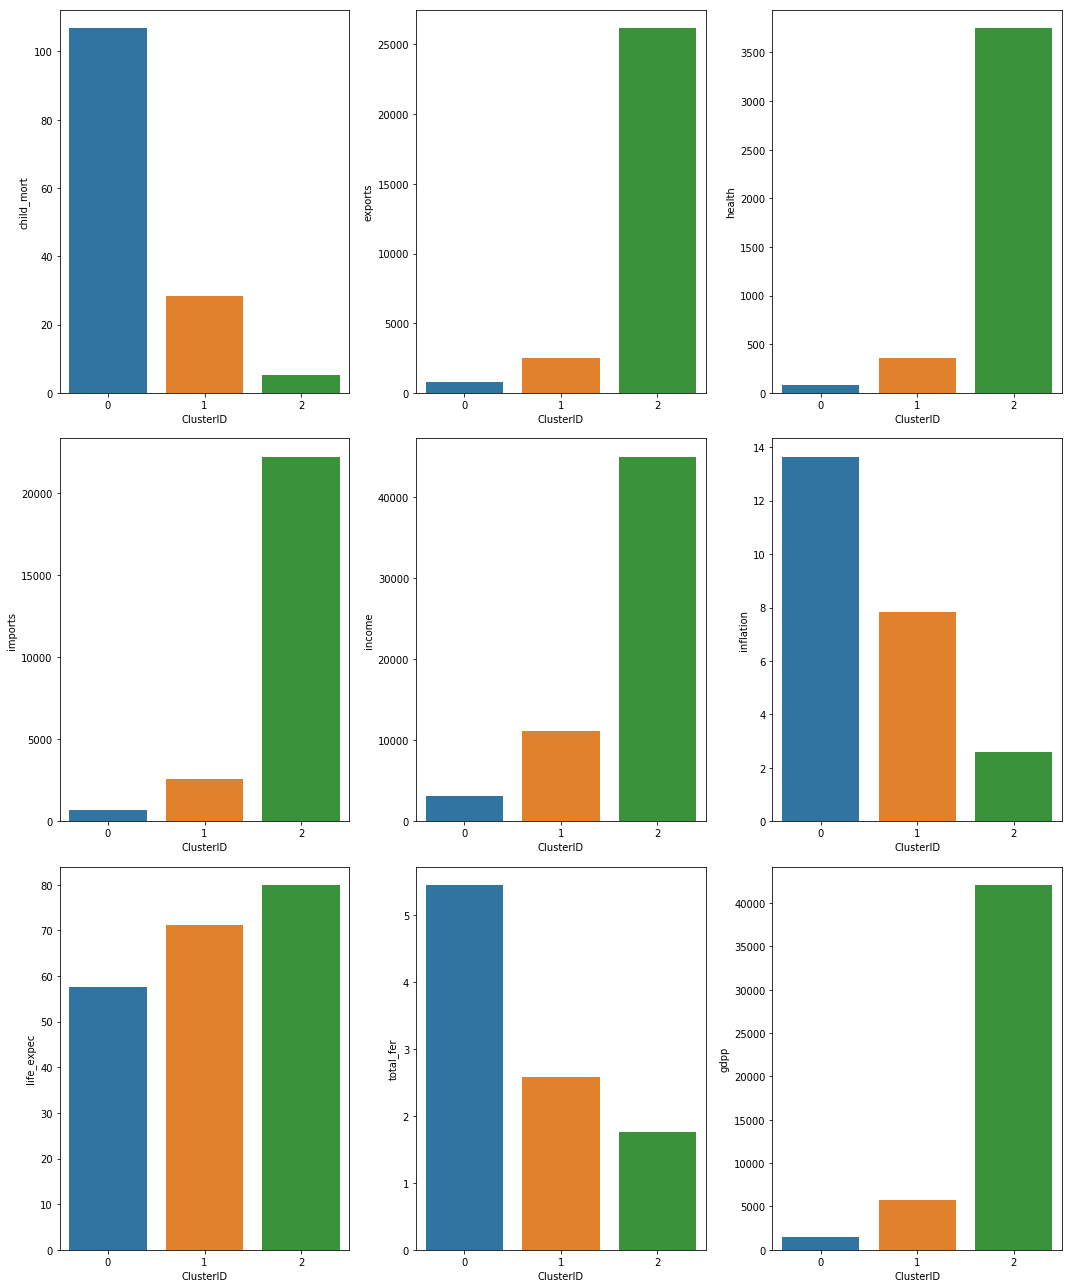

In [92]:
plt.figure(figsize = (15,18))
plot_columns = hc_cluster_anal.columns.tolist()
plot_columns.remove('ClusterID')
i=1
for x in plot_columns:
    plt.subplot(3,3,i)
    sns.barplot(x='ClusterID',y=x,data=hc_cluster_anal)
    i=i+1
plt.tight_layout()
plt.show()

__Cluster0 is the cluster of interested countries__

#### Countries list

In [93]:
print(cluster_hc[cluster_hc.ClusterID ==0].country.tolist())

['Afghanistan', 'Angola', 'Benin', 'Burkina Faso', 'Burundi', 'Cameroon', 'Central African Republic', 'Chad', 'Congo, Dem. Rep.', 'Congo, Rep.', "Cote d'Ivoire", 'Equatorial Guinea', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Lesotho', 'Liberia', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Niger', 'Nigeria', 'Sierra Leone', 'Sudan', 'Tanzania', 'Timor-Leste', 'Togo', 'Uganda', 'Zambia']


The below are the 10 countries that i think require immediate help based on gdpp of the country.

In [94]:
cluster_hc[cluster_hc.ClusterID ==0].sort_values(['gdpp'],ascending = True).head(10).country.tolist()

['Burundi',
 'Liberia',
 'Congo, Dem. Rep.',
 'Niger',
 'Sierra Leone',
 'Mozambique',
 'Central African Republic',
 'Malawi',
 'Togo',
 'Guinea-Bissau']